In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy
import random

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

#### MUST DELETE
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Set up paths & import src functions
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [3]:
# Import data
X_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_X_train.npy')
y_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_y_train.npy')

In [4]:
def tune_lgb(X_train, y_train, param_grid, runs, n_folds, early_stopping_rounds):
    
    '''
    
    This function enables random grid search hyperparameter tuning on the LightGBM
    model. The output is a DataFrame containing the training and cross validation
    AUC scores for each run, along with the associated hyperparameters.
    
    The parameters are as follows:
        1. X_train - feature training set (np.array)
        2. y_train - target variable for training set (np.array)
        3. param_grid - dictionary containing the hyperparameters and associated
           ranges from which the randomly selected hyperparameter values will be
           chosen. E.g, for {'max_depth': [1,2,3]}, the 'max_depth' hyperparamater
           will be randomly chosen from the values [1,2,3]
        4. runs - the number of random iterations of hyperparameters that will be run
           on the model
        5. n_folds - the number of K folds in the training data that will be run to
           find cross validation accuracy
        6. early_stopping_rounds - how many iterations of the LightGBM should be run
           without improvement in cross validation accuracy before each run stops    
    
    '''
    
    # Prepare the output dataframe
    df_cols = list(param_grid.keys()) + ['params', 'training_score', 'valid_score']
    runs_df = pd.DataFrame(columns = df_cols)
    
    run =0
    while run < runs:
        run += 1
        
        # Select the random parameters & train the model
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        train_score, valid_score = train_lgb(X_train=X_train,
                                             y_train=y_train,
                                             n_folds=n_folds,
                                             params=random_params,
                                             eval_metric='auc',
                                             early_stopping_rounds=early_stopping_rounds)
        
        # Add the hyperparameters, training and cross validation scores into the output DF
        temp_df = pd.DataFrame(columns=df_cols)
        
        for c in list(param_grid.keys()):
            temp_df.loc[0, c] = random_params[c]

        temp_df.loc[0, 'params'] = [random_params]
        temp_df.loc[0, 'training_score'] = train_score
        temp_df.loc[0, 'valid_score'] = valid_score

        runs_df = runs_df.append(temp_df)

        del temp_df, train_score, valid_score
        
    runs_df['training_score'] = runs_df['training_score'].astype(float)
    runs_df['valid_score'] = runs_df['valid_score'].astype(float)
    
    return runs_df

In [5]:
def train_lgb(X_train, y_train, n_folds, params, eval_metric, early_stopping_rounds):
    
    '''
    Takes a single set of hyperparameters and runs LightGBM, using K-Fold
    for cross validation scoring.
    
    Outputs the training and cross validation AUC score.
    '''
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for validation predictions
    valid_predictions = np.zeros(X_train.shape[0])
    
    # List for recording training scores
    train_scores = []
        
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(X_train):
        
        # Training data for the fold
        train_features  = X_train[train_indices]
        train_labels = [x for i,x in enumerate(y_train) if i in train_indices]
        # Validation data for the fold
        valid_features = X_train[valid_indices]
        valid_labels = [x for i,x in enumerate(y_train) if i in valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(**params)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric=eval_metric,
                  eval_set = [(valid_features, valid_labels),
                              (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds=early_stopping_rounds,
                  verbose=0)
        
        # Record the best iteration
        best_it = model.best_iteration_
        
        # Record the validation predictions
        valid_predictions[valid_indices] = model.predict_proba(valid_features,
                                                               num_iteration=best_it)[:, 1]
        
        # Record the best training score
        train_score = model.best_score_['train'][eval_metric]        
        train_scores.append(train_score)
    
    # Overall validation score
    valid_auc = roc_auc_score(y_train, valid_predictions)

    # Overall training score
    train_auc = np.mean(train_scores)
        
    return train_auc, valid_auc

In [6]:
# Define the grid search parameters
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(10, 150)),
    'learning_rate': list(np.linspace(0.001, 0.5)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_data_in_leaf': list(range(10, 250, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.001, 1)),
    'subsample': list(np.linspace(0.5, 1)),
    'is_unbalance': [True, False],
    'min_split_gain': list(np.linspace(0.001, 1)),
    'min_data_in_leaf': list(np.arange(1, 200, 3)),
    'n_estimators': list(np.arange(100, 20100, 1000))
}

In [7]:
runs_df = tune_lgb(X_train, y_train, param_grid, runs=250, n_folds=5,
                   early_stopping_rounds=100).reset_index(drop=True)

Best CV Score:  0.8884573424041144


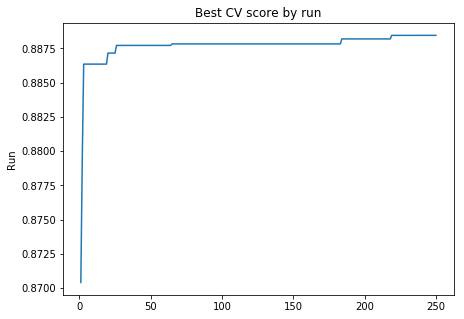

<Figure size 432x288 with 0 Axes>

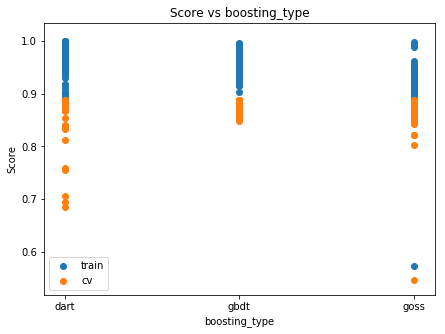

<Figure size 432x288 with 0 Axes>

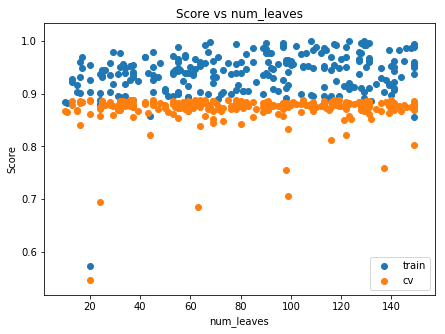

<Figure size 432x288 with 0 Axes>

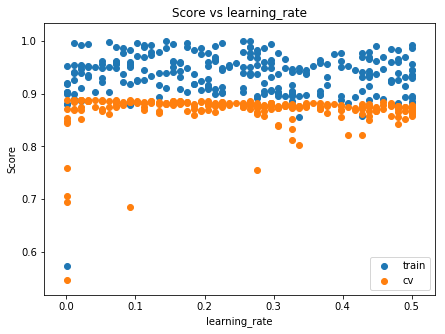

<Figure size 432x288 with 0 Axes>

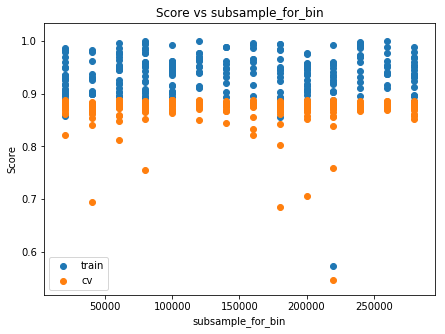

<Figure size 432x288 with 0 Axes>

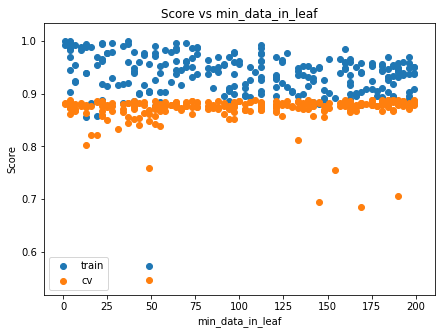

<Figure size 432x288 with 0 Axes>

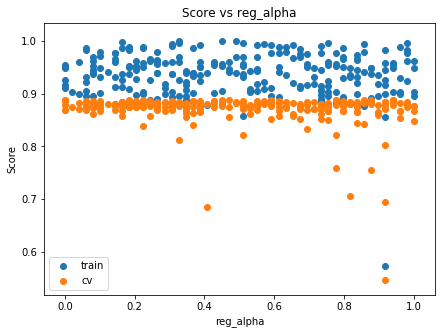

<Figure size 432x288 with 0 Axes>

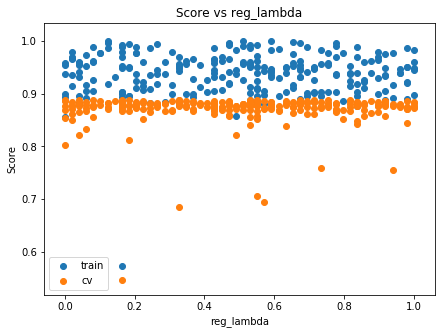

<Figure size 432x288 with 0 Axes>

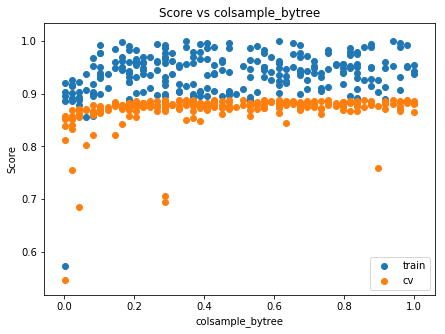

<Figure size 432x288 with 0 Axes>

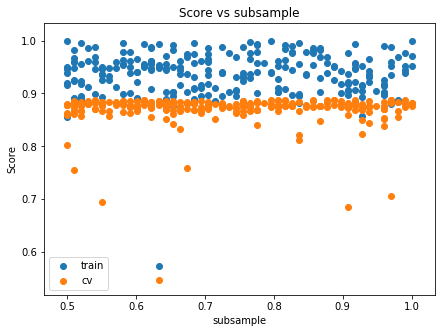

<Figure size 432x288 with 0 Axes>

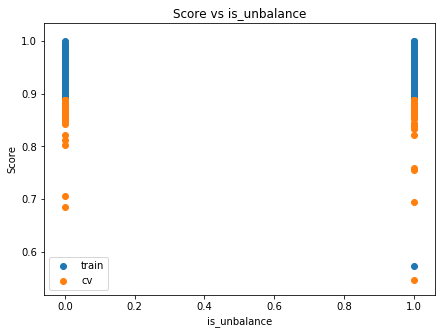

<Figure size 432x288 with 0 Axes>

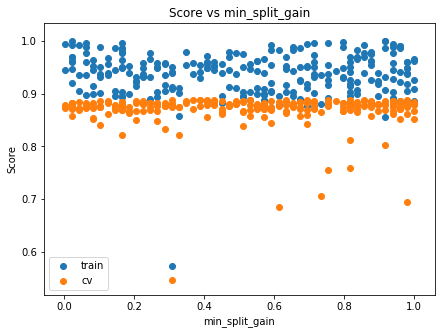

<Figure size 432x288 with 0 Axes>

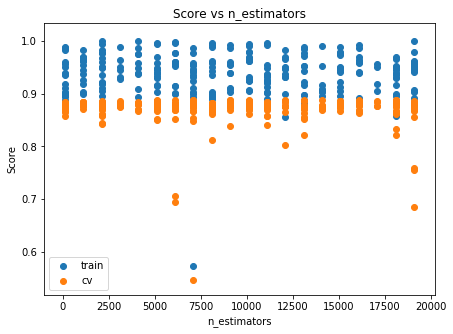

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_data_in_leaf,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,min_split_gain,n_estimators,params,training_score,valid_score
248,gbdt,117,0.0111837,60000,175,0,0.755102,0.429143,0.857143,False,0.388367,7100,"[{'boosting_type': 'gbdt', 'num_leaves': 117, ...",0.954466,0.888457
218,goss,37,0.0111837,120000,109,0.857143,0.0408163,0.469918,0.795918,False,0.388367,16100,"[{'boosting_type': 'goss', 'num_leaves': 37, '...",0.941228,0.888456
183,gbdt,45,0.0417347,20000,199,0.22449,0.183673,0.571857,0.612245,True,0.306816,18100,"[{'boosting_type': 'gbdt', 'num_leaves': 45, '...",0.951128,0.888197
227,gbdt,140,0.031551,100000,175,0.77551,0.530612,0.510694,0.806122,False,0.63302,13100,"[{'boosting_type': 'gbdt', 'num_leaves': 140, ...",0.952544,0.888123
189,dart,119,0.0519184,60000,190,0.877551,0.163265,0.612633,0.887755,False,0.979612,18100,"[{'boosting_type': 'dart', 'num_leaves': 119, ...",0.949101,0.887903
64,goss,20,0.0111837,60000,184,0,0.0816327,0.857286,0.887755,False,0.81651,10100,"[{'boosting_type': 'goss', 'num_leaves': 20, '...",0.925877,0.887832
25,gbdt,64,0.0213673,220000,187,0.938776,0.673469,0.327204,0.918367,True,0.755347,7100,"[{'boosting_type': 'gbdt', 'num_leaves': 64, '...",0.954829,0.887722
209,gbdt,36,0.0213673,200000,187,0.183673,0.326531,0.979612,0.989796,True,0.694184,14100,"[{'boosting_type': 'gbdt', 'num_leaves': 36, '...",0.952291,0.887471
190,dart,62,0.0213673,60000,184,0.469388,0.714286,0.755347,0.540816,True,0.531082,12100,"[{'boosting_type': 'dart', 'num_leaves': 62, '...",0.946970,0.887279
19,dart,78,0.0926531,100000,181,0.77551,0.326531,0.347592,0.612245,True,0.408755,9100,"[{'boosting_type': 'dart', 'num_leaves': 78, '...",0.956471,0.887161


<Figure size 432x288 with 0 Axes>

In [8]:
# Find the best parameters & CV score
best_params=runs_df.loc[runs_df['valid_score'].max() ==
                        runs_df['valid_score'], 'params'].values[0][0]
print('Best CV Score: ', runs_df['valid_score'].max())

# Visualise best CV score by run
best_cv_by_run(runs_df, 'valid_score')

# Visualise the scores by single hyperparameters
plot_single_results(runs_df, 'training_score', 'valid_score', 'params')

runs_df.sort_values(by='valid_score', ascending=False).head(25)

In [9]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=best_params,
          classifier=lgb.LGBMClassifier,
          model_name='light_gbm')